# <span style="color:#ff5f27;">🧬 Modeling</span>

---
## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store</span>

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/164


Connected. Call `.close()` to terminate connection gracefully.


---
## <span style="color:#ff5f27;"> 📝 Imports</span>

In [2]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model, preprocessing
from sklearn.metrics import accuracy_score
from sklearn import metrics


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

import warnings
warnings.filterwarnings('ignore')

---

## <span style="color:#ff5f27;">🪝 Feature View and Training Dataset Retrieval</span>

In [3]:
feature_view = fs.get_feature_view(
    name = 'btc_feature_view',
    version = 1
)

In [4]:
X_train, y_train = feature_view.get_training_data(
    training_dataset_version = 1
)

In [5]:
X_train['close'] = y_train

X_train.sort_values('unix', inplace=True)
X_train["close_nextday"] = X_train.close.shift(-1)

X_train.date = X_train.date.apply(str)
X_train.unix = X_train.unix.apply(int)

X_train.set_index('date',inplace = True)
X_train.dropna(inplace = True)

X_train.head()

,index,open,high,low,volume,quote_av,trades,tb_base_av,tb_quote_av,unix,...,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days,subjectivity,polarity,compound,close,close_nextday
date,,,,,,,,,,,,,,,,,,,,,
2021-02-06,0,38289.32,40955.51,38215.94,98757.311183,3.922095e+09,2291646,52015.513362,2.065181e+09,1612566000000,...,39186.940000,0.000000,0.0,0.0,0.0,39.396726,14.872548,19.337917,39186.94,38795.69
2021-02-07,1,39181.01,39700.00,37351.00,84363.679763,3.256521e+09,1976357,40764.388959,1.574483e+09,1612652400000,...,38987.821696,276.655528,0.0,0.0,0.0,43.991652,18.617581,18.655754,38795.69,46374.87
2021-02-08,2,38795.69,46794.45,37988.89,138597.536914,5.881537e+09,3230961,72345.891568,3.069314e+09,1612738800000,...,41538.626239,4306.962346,0.0,0.0,0.0,63.704263,23.015734,37.119012,46374.87,46420.42
2021-02-09,3,46374.86,48142.19,44961.09,115499.861712,5.386255e+09,3119034,57429.564347,2.679451e+09,1612825200000,...,42825.220050,4279.624726,0.0,0.0,0.0,49.481201,18.047544,28.974629,46420.42,44807.58
2021-02-10,4,46420.42,47310.00,43727.00,97154.182200,4.431650e+09,2891592,47971.985731,2.190231e+09,1612911600000,...,43250.507857,3783.716931,0.0,0.0,0.0,39.117133,13.832576,25.452771,44807.58,47969.51


In [6]:
X = X_train.drop(labels=["close_nextday", "unix"], axis=1)
y = X_train['close_nextday']

In [7]:
X.head()

,index,open,high,low,volume,quote_av,trades,tb_base_av,tb_quote_av,mean_7_days,...,std_56_days,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days,subjectivity,polarity,compound,close
date,,,,,,,,,,,,,,,,,,,,,
2021-02-06,0,38289.32,40955.51,38215.94,98757.311183,3.922095e+09,2291646,52015.513362,2.065181e+09,0.0,...,0.0,39186.940000,0.000000,0.0,0.0,0.0,39.396726,14.872548,19.337917,39186.94
2021-02-07,1,39181.01,39700.00,37351.00,84363.679763,3.256521e+09,1976357,40764.388959,1.574483e+09,0.0,...,0.0,38987.821696,276.655528,0.0,0.0,0.0,43.991652,18.617581,18.655754,38795.69
2021-02-08,2,38795.69,46794.45,37988.89,138597.536914,5.881537e+09,3230961,72345.891568,3.069314e+09,0.0,...,0.0,41538.626239,4306.962346,0.0,0.0,0.0,63.704263,23.015734,37.119012,46374.87
2021-02-09,3,46374.86,48142.19,44961.09,115499.861712,5.386255e+09,3119034,57429.564347,2.679451e+09,0.0,...,0.0,42825.220050,4279.624726,0.0,0.0,0.0,49.481201,18.047544,28.974629,46420.42
2021-02-10,4,46420.42,47310.00,43727.00,97154.182200,4.431650e+09,2891592,47971.985731,2.190231e+09,0.0,...,0.0,43250.507857,3783.716931,0.0,0.0,0.0,39.117133,13.832576,25.452771,44807.58


In [8]:
y.head()

date
2021-02-06    38795.69
2021-02-07    46374.87
2021-02-08    46420.42
2021-02-09    44807.58
2021-02-10    47969.51
Name: close_nextday, dtype: float64

---

## <span style="color:#ff5f27;">🪓 TimeSeriesSplit</span>

In [9]:
tss = TimeSeriesSplit(n_splits=3)  

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_split, y_test_split = y.iloc[train_index], y.iloc[test_index]

In [10]:
y_train = y_train_split.values.reshape(-1, 1)
y_test = y_test_split.values.reshape(-1, 1)

---

## <span style="color:#ff5f27;">🤖 Random Forest</span>

In [11]:
rf_model = RandomForestRegressor().fit(X_train, y_train)

In [12]:
y_preds = rf_model.predict(X_test)

In [13]:
metrics.mean_absolute_error(y_test,y_preds)

1754.8272725000008

In [14]:
metrics.r2_score(y_test,y_preds)

0.812479106472645

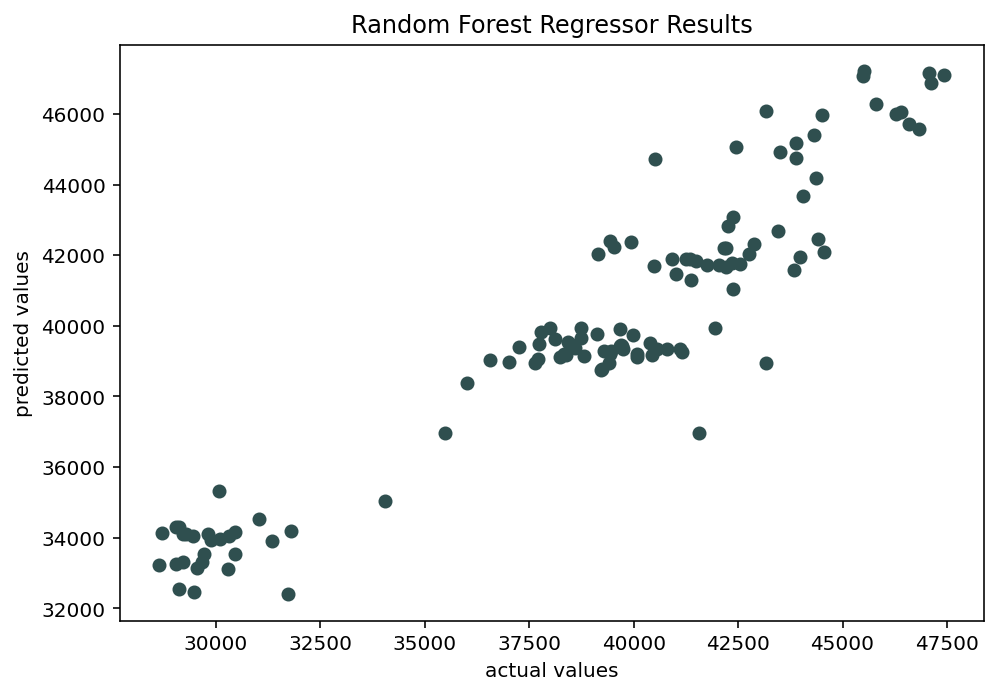

In [15]:
colors = ['darkslategrey']

fig=plt.figure()
ax=fig.add_axes([0, 0, 1, 1])
ax.scatter(y_test, y_preds, c=colors)

ax.set_title('Random Forest Regressor Results')
ax.set_xlabel('actual values')
ax.set_ylabel('predicted values')

fig.tight_layout()
plt.show()

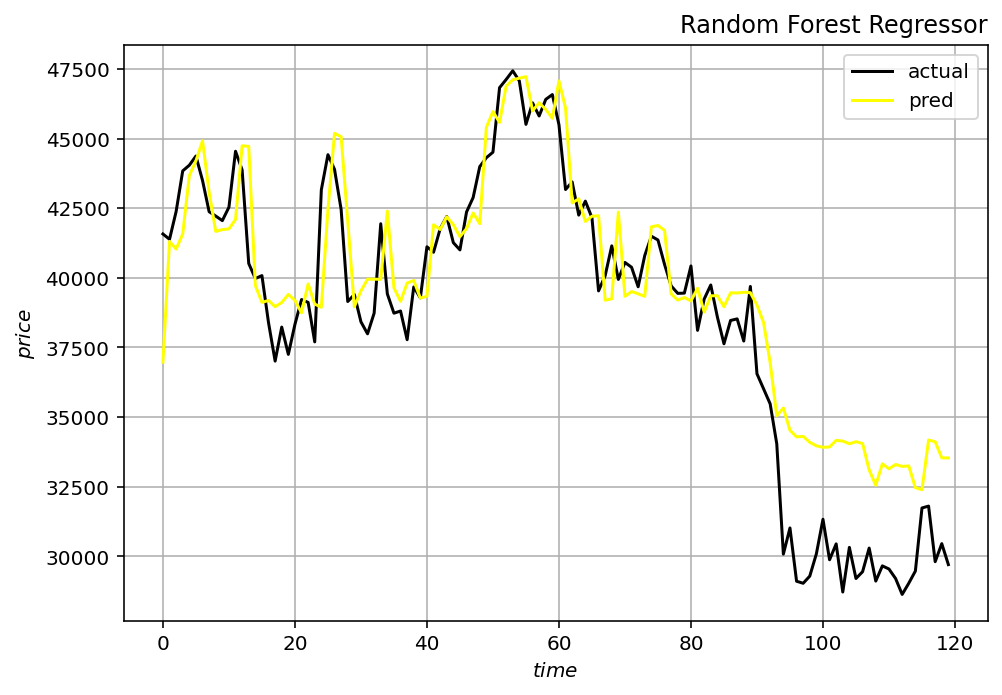

In [16]:
colors = ['darkslategrey']

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.plot(y_test, 'black')
ax.plot(y_preds, 'yellow')
ax.set_ylabel('$price$')
ax.set_xlabel('$time$')
ax.grid(True)
ax.legend(["actual", "pred"])
ax.set_title("Random Forest Regressor", loc='right')

fig.tight_layout()

plt.grid(True)
plt.show()

In [17]:
feat_labels = X_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) close                          0.835505
 2) low                            0.079060
 3) high                           0.033693
 4) exp_std_56_days                0.011617
 5) open                           0.009858
 6) std_14_days                    0.001980
 7) exp_mean_7_days                0.001974
 8) exp_std_14_days                0.001908
 9) index                          0.001646
10) std_7_days                     0.001526
11) exp_std_7_days                 0.001384
12) momentum_56_days               0.001315
13) momentum_14_days               0.001309
14) std_56_days                    0.001298
15) strength_index_14_days         0.001271
16) momentum_7_days                0.001265
17) mean_56_days                   0.001139
18) rate_of_change_7_days          0.001083
19) rate_of_change_56_days         0.000980
20) strength_index_7_days          0.000979
21) exp_mean_14_days               0.000957
22) strength_index_56_days         0.000939
23) rate_of_change_14_days      

---
## <span style='color:#ff5f27'>☁️ Model Registry</span>

In [18]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [19]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'index', 'type': 'int64'},
   {'name': 'open', 'type': 'float64'},
   {'name': 'high', 'type': 'float64'},
   {'name': 'low', 'type': 'float64'},
   {'name': 'volume', 'type': 'float64'},
   {'name': 'quote_av', 'type': 'float64'},
   {'name': 'trades', 'type': 'int64'},
   {'name': 'tb_base_av', 'type': 'float64'},
   {'name': 'tb_quote_av', 'type': 'float64'},
   {'name': 'mean_7_days', 'type': 'float64'},
   {'name': 'mean_14_days', 'type': 'float64'},
   {'name': 'mean_56_days', 'type': 'float64'},
   {'name': 'signal', 'type': 'float64'},
   {'name': 'std_7_days', 'type': 'float64'},
   {'name': 'exp_mean_7_days', 'type': 'float64'},
   {'name': 'exp_std_7_days', 'type': 'float64'},
   {'name': 'momentum_7_days', 'type': 'float64'},
   {'name': 'rate_of_change_7_days', 'type': 'float64'},
   {'name': 'strength_index_7_days', 'type': 'float64'},
   {'name': 'std_14_days', 'type': 'float64'},
   {'name': 'exp_mean_14_days', 'type': 'flo

In [20]:
import joblib

pkl_file_name = "model.pkl"

joblib.dump(rf_model, pkl_file_name)

model = mr.python.create_model(
    name="btcforest",
    #metrics=metrics,
    description=f"btcforest model trained on timeseries and processed tweets.",
    input_example=X_train.sample(),
    model_schema=model_schema
)

model.save(pkl_file_name)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/164/models/btcforest/1


Model(name: 'btcforest', version: 1)

---

In [22]:
%%writefile predict_example.py
import os
import hsfs
import joblib
import numpy as np

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/btcforest.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        return self.model.predict(np.array(inputs).reshape(1, -1)).tolist()

Overwriting predict_example.py


In [23]:
import os
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

Uploading: 0.000%|          | 0/514 elapsed<00:00 remaining<?

In [24]:
# Use the model name from the previous notebook.
model = mr.get_model("btcforest", version = 1)

# Give it any name you want
deployment = model.deploy(
    name="btcforest", 
    model_server="PYTHON",
    script_file=predictor_script_path
)

Deployment created, explore it at https://c.app.hopsworks.ai:443/p/167/deployments/165
Before making predictions, start the deployment by using `.start()`


In [25]:
# get Hopsworks Model Serving
ms = project.get_model_serving()

# get deployment object
deployment = ms.get_deployment("btcforest")

Connected. Call `.close()` to terminate connection gracefully.


In [26]:
deployment.start()

  0%|          | 0/1 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


In [27]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://c.app.hopsworks.ai:443/p/167/deployments/165

Instance name: btcforest-predictor-default-00001-deployment-66fd5d499b-68rgm
[I 220719 11:53:16 kserve-component-server:95] Initializing predictor for deployment: btcforest
[I 220719 11:53:16 kfserver:150] Registering model: btcforest
[I 220719 11:53:16 kfserver:120] Setting asyncio max_workers as 5
[I 220719 11:53:16 kfserver:127] Listening on port 8080
[I 220719 11:53:16 kfserver:129] Will fork 1 workers




---
## <span style='color:#ff5f27'>🔮 Predicting</span>

In [28]:
model.input_example

[361.0,
 38466.9,
 39265.2,
 38000.0,
 34574.44663,
 1334266166.7099988,
 917617.0,
 17730.99304,
 684446571.1793659,
 38548.85937003968,
 38544.869486607146,
 38527.74459201389,
 0.5694444444444444,
 68.01540673768636,
 38548.96366042243,
 87.13496342623749,
 8.611145833333316,
 0.0200939003617234,
 51.87780480074642,
 96.69793538644036,
 38545.46025321049,
 117.77057826750992,
 14.474479166666647,
 0.0379625667253219,
 51.313976232482965,
 162.0385436482857,
 38524.60561742916,
 175.77815587191262,
 38.281666666666624,
 0.1032289944975049,
 51.569746473541095,
 0.0,
 0.0,
 0.0,
 38694.59]

In [29]:
data = {
    "inputs": model.input_example
}

deployment.predict(data)

{'predictions': [37780.38989999998]}

In [30]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://c.app.hopsworks.ai:443/p/167/deployments/165

Instance name: btcforest-predictor-default-00001-deployment-66fd5d499b-68rgm
[I 220719 11:53:16 kserve-component-server:95] Initializing predictor for deployment: btcforest
[I 220719 11:53:16 kfserver:150] Registering model: btcforest
[I 220719 11:53:16 kfserver:120] Setting asyncio max_workers as 5
[I 220719 11:53:16 kfserver:127] Listening on port 8080
[I 220719 11:53:16 kfserver:129] Will fork 1 workers
[I 220719 11:53:20 web:2246] 200 POST /v1/models/btcforest:predict (127.0.0.1) 7.61ms




---